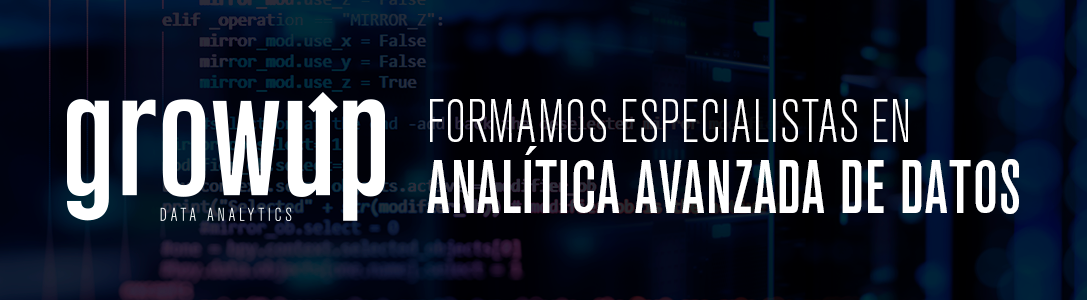

# **LIVE Antes del Machine Learning… entiende tus datos con Python**

## **1. Introducción y contexto**

El presente cuaderno desarrolla un Análisis Exploratorio de Datos (EDA) orientado a la modelización de series temporales (forecast) sobre un conjunto de datos sintético que representa las ventas diarias de Walmart durante el periodo 2022–2024, con especial interés en el comportamiento observado en los meses de noviembre, asociados a la campaña comercial de Black November.

El objetivo principal es comprender la estructura temporal de las ventas, identificando:

- La tendencia general a lo largo de los tres años.  
- Patrones de estacionalidad anual y mensual.  
- Posibles efectos específicos durante la campaña Black November.  
- El papel de variables como categoría de producto, canal de venta y tipo de tienda.

Esta comprensión es un paso previo necesario antes de construir modelos de pronóstico (como ARIMA, Prophet u otros), ya que permite detectar patrones, anomalías y relaciones que influyen directamente en la calidad de las predicciones.

### **1.1 Descripción general del dataset**

El dataset contiene información agregada a nivel diario y cuenta, de forma general, con las siguientes variables:

- Variables temporales:  
  - `fecha`: fecha del registro de ventas.  
  - `anio`: año de la observación (2022, 2023, 2024).  
  - `mes`: mes de la observación (1 a 12).  

- Variables de negocio:  
  - `ventas_diarias`: monto total de ventas del día.  
  - `transacciones`: número de transacciones registradas ese día.  
  - `descuento_promedio`: porcentaje promedio de descuento aplicado en el día.  

- Variables de segmentación:  
  - `categoria`: categoría de producto (por ejemplo, Electrónica, Hogar, Ropa, etc.).  
  - `canal_venta`: canal de venta (Online, Tienda).  
  - `tipo_tienda`: tipo de tienda (Supercenter, Neighborhood Market, Sam’s Club).  
  - `tipo_promocion`: tipo de promoción activa (Sin Promoción, Black November, Black Friday, Cyber Monday).

En las siguientes secciones se procederá a cargar el dataset, verificar su estructura, y posteriormente analizar la serie temporal consolidada y por segmentos, con énfasis en su adecuación para tareas de pronóstico.


In [12]:
# 1. Introducción y contexto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Configuraciones generales de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

### **Preguntas Clave del Análisis Exploratorio de Datos (EDA) para Forecasting**

**Preguntas clave**

- ¿Cuál es el periodo temporal cubierto por el dataset (inicio y fin)?

- ¿Cuál es la frecuencia de los datos (diaria, semanal, mensual)?

- ¿Hay valores faltantes, duplicados o inconsistencias en las fechas?

- ¿Qué variables son relevantes para el forecast (target y predictores)?

## **2. Carga y exploración del dataset**

En esta sección se carga el conjunto de datos y se realiza una primera exploración general para verificar su estructura, tipos de datos, y coherencia temporal.  
Dado que el análisis está orientado a la construcción de modelos de pronóstico, la variable temporal (`fecha`) será el eje principal del estudio.

### **2.1 Carga de datos**
El archivo se encuentra en formato CSV y contiene información diaria de ventas de 2022 a 2024.  
Se utilizará la librería `pandas` para su lectura y transformación inicial.




In [13]:
# 2. Carga y exploración del dataset

# Cargar dataset
df = pd.read_csv("black_november_walmart.csv")

df.head(5)


,anio,fecha,tienda_id,nombre_tienda,ciudad,estado,tipo_tienda,canal_venta,categoria,producto,marca,precio_lista,descuento_pct,precio_final,cantidad,ingreso_total,es_black_friday,es_cyber_monday,es_black_november,es_promocion,tipo_promocion,segmento_cliente,canal_pago,dia_semana,es_fin_de_semana
0,2023,2023-11-13,5,Walmart Supercenter Houston,Houston,Texas,Supercenter,Tienda,Tecnología,"Lenovo IdeaPad 3 15.6""",Lenovo,536.80,20.91,424.53,2,849.06,0,0,1,1,Black November,Joven,Tarjeta,0,0
1,2023,2023-11-24,6,Walmart Supercenter San Antonio,San Antonio,Texas,Supercenter,Online,Ropa,Parka acolchada invierno hombre,George,72.46,60.08,28.93,1,28.93,1,0,1,1,Black Friday,Adulto,Tarjeta,4,1
2,2024,2024-11-22,15,Walmart Neighborhood Market Austin,Austin,Texas,Neighborhood Market,Online,Electrónica,Apple iPhone 15 Pro 128GB,Apple,"1,227.44",47.35,646.24,1,646.24,1,0,1,1,Black Friday,Adulto,Tarjeta,4,1
3,2024,2024-11-15,14,Walmart Neighborhood Market Miami Beach,Miami Beach,Florida,Neighborhood Market,Tienda,Hogar,Philips Airfryer XL 4.2Qt,Philips,219.77,0.00,219.77,1,219.77,0,0,1,0,Sin promo,Joven,Tarjeta,4,1
4,2022,2022-11-25,6,Walmart Supercenter San Antonio,San Antonio,Texas,Supercenter,Tienda,Hogar,NutriBullet Blender Pro 900,NutriBullet,78.98,64.03,28.41,3,85.23,1,0,1,1,Black Friday,Senior,Tarjeta,4,1


### **2.2 Exploración general**
Las tareas iniciales incluyen:

- Verificación de los tipos de datos (`dtypes`).  
- Exploración de los primeros y últimos registros (`head()` y `tail()`).  
- Revisión de la estructura y cantidad de valores nulos (`info()`).  
- Estadísticas descriptivas de las variables numéricas (`describe()`).  
- Conteo de registros por año y mes para asegurar la consistencia temporal.

Este análisis permitirá confirmar que la base de datos es adecuada para su uso en el análisis de series temporales y modelos de forecast.

In [14]:
df["fecha"] = pd.to_datetime(df["fecha"])   # convierte el campo fecha de texto a fecha

display(df.head(5))  # 5 rimeros registros con fecha como fecha datetime
display(df.tail(5))  # 5 úiltimos


,anio,fecha,tienda_id,nombre_tienda,ciudad,estado,tipo_tienda,canal_venta,categoria,producto,marca,precio_lista,descuento_pct,precio_final,cantidad,ingreso_total,es_black_friday,es_cyber_monday,es_black_november,es_promocion,tipo_promocion,segmento_cliente,canal_pago,dia_semana,es_fin_de_semana
0,2023,2023-11-13,5,Walmart Supercenter Houston,Houston,Texas,Supercenter,Tienda,Tecnología,"Lenovo IdeaPad 3 15.6""",Lenovo,536.80,20.91,424.53,2,849.06,0,0,1,1,Black November,Joven,Tarjeta,0,0
1,2023,2023-11-24,6,Walmart Supercenter San Antonio,San Antonio,Texas,Supercenter,Online,Ropa,Parka acolchada invierno hombre,George,72.46,60.08,28.93,1,28.93,1,0,1,1,Black Friday,Adulto,Tarjeta,4,1
2,2024,2024-11-22,15,Walmart Neighborhood Market Austin,Austin,Texas,Neighborhood Market,Online,Electrónica,Apple iPhone 15 Pro 128GB,Apple,"1,227.44",47.35,646.24,1,646.24,1,0,1,1,Black Friday,Adulto,Tarjeta,4,1
3,2024,2024-11-15,14,Walmart Neighborhood Market Miami Beach,Miami Beach,Florida,Neighborhood Market,Tienda,Hogar,Philips Airfryer XL 4.2Qt,Philips,219.77,0.00,219.77,1,219.77,0,0,1,0,Sin promo,Joven,Tarjeta,4,1
4,2022,2022-11-25,6,Walmart Supercenter San Antonio,San Antonio,Texas,Supercenter,Tienda,Hogar,NutriBullet Blender Pro 900,NutriBullet,78.98,64.03,28.41,3,85.23,1,0,1,1,Black Friday,Senior,Tarjeta,4,1


,anio,fecha,tienda_id,nombre_tienda,ciudad,estado,tipo_tienda,canal_venta,categoria,producto,marca,precio_lista,descuento_pct,precio_final,cantidad,ingreso_total,es_black_friday,es_cyber_monday,es_black_november,es_promocion,tipo_promocion,segmento_cliente,canal_pago,dia_semana,es_fin_de_semana
9995,2023,2023-11-24,12,Walmart Supercenter Atlanta,Atlanta,Georgia,Supercenter,Tienda,Hogar,Philips Airfryer XL 4.2Qt,Philips,171.40,37.59,106.98,1,106.98,1,0,1,1,Black Friday,Adulto,Tarjeta,4,1
9996,2023,2023-11-03,2,Walmart Supercenter Miami,Miami,Florida,Supercenter,Online,Ropa,Parka acolchada invierno hombre,George,49.40,0.00,49.40,4,197.60,0,0,1,0,Sin promo,Adulto,Online Pay,4,1
9997,2023,2023-11-27,12,Walmart Supercenter Atlanta,Atlanta,Georgia,Supercenter,Online,Juguetes,Hot Wheels Mega Pista,Hot Wheels,78.00,45.70,42.36,1,42.36,0,1,1,1,Cyber Monday,Senior,Tarjeta,0,0
9998,2024,2024-11-18,17,Walmart Neighborhood Market San Jose,San Jose,California,Neighborhood Market,Tienda,Alimentos,Pack 24 latas Coca-Cola 355ml,Coca-Cola,9.12,13.23,7.91,2,15.82,0,0,1,1,Black November,Joven,Tarjeta,0,0
9999,2022,2022-11-25,6,Walmart Supercenter San Antonio,San Antonio,Texas,Supercenter,Tienda,Electrónica,Apple AirPods Pro (2nd Gen),Apple,202.38,51.76,97.62,2,195.24,1,0,1,1,Black Friday,Joven,Online Pay,4,1


In [15]:
print("--- Información del dataset ---")
df.info()

--- Información del dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   anio               10000 non-null  int64         
 1   fecha              10000 non-null  datetime64[ns]
 2   tienda_id          10000 non-null  int64         
 3   nombre_tienda      10000 non-null  object        
 4   ciudad             10000 non-null  object        
 5   estado             10000 non-null  object        
 6   tipo_tienda        10000 non-null  object        
 7   canal_venta        10000 non-null  object        
 8   categoria          10000 non-null  object        
 9   producto           10000 non-null  object        
 10  marca              10000 non-null  object        
 11  precio_lista       10000 non-null  float64       
 12  descuento_pct      10000 non-null  float64       
 13  precio_final       10000 non-n

In [16]:
print("--- Estadísticas descriptivas ---")
display(df.describe().T)

--- Estadísticas descriptivas ---


,count,mean,min,25%,50%,75%,max,std
anio,"10,000.00","2,023.02","2,022.00","2,022.00","2,023.00","2,024.00","2,024.00",0.82
fecha,10000,2023-11-25 16:09:41.760000,2022-11-01 00:00:00,2022-11-25 00:00:00,2023-11-24 00:00:00,2024-11-13 00:00:00,2024-11-30 00:00:00,NaN
tienda_id,"10,000.00",10.44,1.00,5.00,10.00,16.00,20.00,5.80
precio_lista,"10,000.00",278.43,3.00,30.30,80.58,485.04,"1,998.53",368.12
descuento_pct,"10,000.00",23.27,0.00,0.00,22.88,42.70,69.98,22.91
precio_final,"10,000.00",211.56,1.08,20.50,62.38,310.99,"1,969.86",295.93
cantidad,"10,000.00",2.44,1.00,1.00,2.00,3.00,7.00,1.55
ingreso_total,"10,000.00",340.42,1.30,54.57,141.32,420.95,"3,931.40",473.15
es_black_friday,"10,000.00",0.30,0.00,0.00,0.00,1.00,1.00,0.46
es_cyber_monday,"10,000.00",0.10,0.00,0.00,0.00,0.00,1.00,0.29


In [17]:
print("--- Valores nulos totales ---")
print(df.isnull().sum())

--- Valores nulos totales ---
anio                 0
fecha                0
tienda_id            0
nombre_tienda        0
ciudad               0
estado               0
tipo_tienda          0
canal_venta          0
categoria            0
producto             0
marca                0
precio_lista         0
descuento_pct        0
precio_final         0
cantidad             0
ingreso_total        0
es_black_friday      0
es_cyber_monday      0
es_black_november    0
es_promocion         0
tipo_promocion       0
segmento_cliente     0
canal_pago           0
dia_semana           0
es_fin_de_semana     0
dtype: int64


In [18]:
print("--- Registros por año ---")
print(df["anio"].value_counts().sort_index())

--- Registros por año ---
anio
2022    3252
2023    3310
2024    3438
Name: count, dtype: int64


In [19]:
print("--- Registros por mes ---")   
# 1. Create the 'mes' column from 'fecha'
df['mes'] = df['fecha'].dt.month

# 2. Now run your line again
print(df["mes"].value_counts().sort_index())


--- Registros por mes ---
mes
11    10000
Name: count, dtype: int64


### **Preguntas clave para la Sección 3**

- ¿Se observa una tendencia creciente o decreciente a lo largo de los años?

- ¿Cómo varían las ventas promedio por mes o por año?

- ¿Existen patrones o rupturas estructurales (picos, caídas)?

- ¿Qué tan estable es la serie a lo largo del tiempo?

## **3. Análisis temporal general**

En esta sección se examina la evolución de las ventas diarias a lo largo del tiempo para identificar patrones, tendencias y posibles estacionalidades.  
Dado que la variable `fecha` representa una serie temporal continua entre 2022 y 2024, este análisis permitirá evaluar el comportamiento global de las ventas, así como los picos característicos de los periodos promocionales (especialmente en noviembre).



### **3.1 Evolución general de ventas diarias**

Se agrupan y visualizan las ventas por fecha para obtener una vista general de la serie temporal, observando:
- Tendencia global (crecimiento o decrecimiento en el tiempo).  
- Variabilidad a corto plazo (fluctuaciones diarias).  
- Picos o anomalías estacionales.



In [34]:
# Paso 1: Calcular el valor total de cada fila (venta individual)
# Multiplicamos el precio por la cantidad
df["ventas_diarias"] = df["precio_final"] * df["cantidad"]

# Paso 2: Ahora agrupamos por fecha para obtener el total del día
serie_diaria = df.groupby("fecha", as_index=False)["ventas_diarias"].sum()

# Paso 3: Tu gráfico ahora funcionará perfectamente
import plotly.express as px

fig = px.line(
    serie_diaria,
    x="fecha",
    y="ventas_diarias",
    title="Evolución de las ventas diarias",
    labels={"ventas_diarias": "Total Ventas (USD)", "fecha": "Fecha"}
)  
# 1. Calculamos la media móvil de 7 días
serie_diaria['media_7_dias'] = serie_diaria['ventas_diarias'].rolling(window=7).mean()

# 2. Actualizamos el gráfico para incluir ambas líneas
import plotly.graph_objects as go

fig = go.Figure()

# Línea de ventas diarias (un poco más clara para que no distraiga)
fig.add_trace(go.Scatter(x=serie_diaria['fecha'], y=serie_diaria['ventas_diarias'],
                         mode='lines', name='Ventas Diarias',
                         line=dict(color='rgba(31, 119, 180, 0.3)')))

# Línea de tendencia (Media Móvil) - más gruesa y sólida
fig.add_trace(go.Scatter(x=serie_diaria['fecha'], y=serie_diaria['media_7_dias'],
                         mode='lines', name='Tendencia (7 días)',
                         line=dict(color='red', width=3)))

fig.update_layout(title="Ventas Diarias vs. Tendencia Semanal",
                  xaxis_title="Fecha", yaxis_title="Ventas (USD)")
fig.show()



In [35]:
# 1. Extraer el nombre del día de la semana (en inglés o español dependiendo de tu sistema)
# Usamos .dt.day_name() para obtener el nombre
df['dia_nombre'] = df['fecha'].dt.day_name()

# 2. Agrupar por el nombre del día y sumar las ventas
ventas_dia_semana = df.groupby('dia_nombre', as_index=False)['ventas_diarias'].sum()

# 3. IMPORTANTE: Ordenar los días correctamente (para que no salgan en orden alfabético)
dias_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Si tus nombres salen en español, usa: ["Monday", "Tuesday", etc.] o cámbialos aquí:
# dias_ordenados = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

# 4. Crear el gráfico de barras
import plotly.express as px

fig = px.bar(
    ventas_dia_semana, 
    x='dia_nombre', 
    y='ventas_diarias',
    title='Ventas Totales por Día de la Semana',
    labels={'ventas_diarias': 'Ventas Totales (USD)', 'dia_nombre': 'Día'},
    category_orders={"dia_nombre": dias_ordenados}, # Esto fuerza el orden cronológico
    color='ventas_diarias', # El color cambia según el volumen de venta
    color_continuous_scale='Viridis'
)

fig.show()

### **3.2 Comportamiento interanual**

Se comparan los valores promedios mensuales por año para determinar:
- El crecimiento o decrecimiento entre años.  
- Meses con comportamiento atípico (por ejemplo, noviembre durante campañas de Black November).  

In [ ]:
# Calcular ventas promedio por mes y año
promedio_mensual = (
    df.groupby(["anio", "mes"], as_index=False)["ventas_diarias"]
    .mean()
    .sort_values(["anio", "mes"])
)

# Crear gráfico comparativo por año
fig = px.line(
    promedio_mensual,
    x="mes",
    y="ventas_diarias",
    color="anio",
    markers=True,
    title="Promedio mensual de ventas por año",
    labels={"ventas_diarias": "Ventas promedio (USD)", "mes": "Mes", "anio": "Año"},
)
fig.update_layout(xaxis=dict(dtick=1))
fig.show()


### **Preguntas clave para la Sección 4**
- ¿Cuál es la forma de la tendencia (lineal, no lineal)?

- ¿Cómo se comporta la estacionalidad (mensual, semanal)?

- ¿Qué magnitud tiene el componente aleatorio o ruido?

- ¿El modelo aditivo o multiplicativo se ajusta mejor?

## **4. Descomposición de la serie temporal**

En esta sección se realiza la **descomposición de la serie temporal** de ventas diarias, con el fin de identificar los tres componentes fundamentales que explican su comportamiento:

1. **Tendencia:** evolución general de las ventas a lo largo del tiempo, asociada al crecimiento o decrecimiento estructural del negocio.  
2. **Estacionalidad:** fluctuaciones periódicas que se repiten en intervalos regulares (por ejemplo, picos anuales en noviembre y diciembre).  
3. **Ruido o componente irregular:** variaciones aleatorias que no siguen un patrón sistemático.

### **4.1 Preparación de la serie temporal**

Antes de aplicar el modelo de descomposición, se agrupan las ventas diarias en una serie temporal consolidada, asegurando que la frecuencia sea **diaria** y sin valores faltantes.  
Posteriormente, se utiliza la función `seasonal_decompose` del módulo `statsmodels` para visualizar los tres componentes.


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Asegurar una serie diaria continua
serie_diaria = df.groupby("fecha", as_index=False)["ventas_diarias"].sum().set_index("fecha")

# Asegurar frecuencia diaria explícita
serie_diaria = serie_diaria.asfreq("D")

# Aplicar descomposición aditiva
descomposicion = seasonal_decompose(serie_diaria["ventas_diarias"], model="additive", period=365)

# Visualización
fig = descomposicion.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Descomposición de la serie temporal de ventas diarias (modelo aditivo)", fontsize=14)
plt.show()


ValueError: This function does not handle missing values

### **Preguntas clave para la Sección 5**

- ¿Qué meses o semanas concentran el mayor volumen de ventas?

- ¿Hay diferencias significativas por canal o categoría?

- ¿Qué impacto tienen los eventos promocionales sobre las ventas?

- ¿Existen patrones recurrentes por día de la semana?

## **5. Análisis estacional y comparativo**

En esta sección se analiza la estacionalidad desde diferentes perspectivas, observando los patrones que se repiten periódicamente y cómo estos varían entre categorías y canales de venta.

### **5.1 Estacionalidad mensual**
Se calcula el promedio de ventas por mes, considerando los tres años del periodo, para identificar los meses con mayor actividad comercial y confirmar la presencia de picos en noviembre.




In [25]:
ventas_mes = (
    df.groupby("mes", as_index=False)["ventas_diarias"]
    .mean()
    .sort_values("mes")
)

fig = px.bar(
    ventas_mes,
    x="mes",
    y="ventas_diarias",
    title="Promedio mensual de ventas (2022–2024)",
    labels={"mes": "Mes", "ventas_diarias": "Ventas promedio (USD)"},
    text_auto=".2s",
)
fig.update_traces(marker_color="#1f77b4")
fig.update_layout(xaxis=dict(dtick=1))
fig.show()


### **5.2 Estacionalidad semanal**
Se analiza la variación promedio de ventas por día de la semana, lo que permite identificar patrones de comportamiento en la frecuencia de compra (por ejemplo, mayores ventas los fines de semana o días laborales).


In [26]:
df["dia_semana"] = df["fecha"].dt.day_name()

ventas_semana = (
    df.groupby("dia_semana", as_index=False)["ventas_diarias"]
    .mean()
)

# Ordenar días de lunes a domingo
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ventas_semana["dia_semana"] = pd.Categorical(ventas_semana["dia_semana"], categories=orden_dias, ordered=True)
ventas_semana = ventas_semana.sort_values("dia_semana")

fig = px.bar(
    ventas_semana,
    x="dia_semana",
    y="ventas_diarias",
    title="Promedio de ventas por día de la semana",
    labels={"dia_semana": "Día de la semana", "ventas_diarias": "Ventas promedio (USD)"},
    text_auto=".2s",
)
fig.update_traces(marker_color="#007acc")
fig.show()


### **5.3 Comparativo por categoría y canal de venta**
Finalmente, se comparan las ventas promedio por categoría de producto y canal de venta (Online vs Tienda) para detectar segmentos con mayor crecimiento o participación durante el periodo.

In [27]:
ventas_categoria = (
    df.groupby(["categoria", "canal_venta"], as_index=False)["ventas_diarias"]
    .mean()
)

fig = px.bar(
    ventas_categoria,
    x="categoria",
    y="ventas_diarias",
    color="canal_venta",
    barmode="group",
    title="Promedio de ventas por categoría y canal de venta",
    labels={"categoria": "Categoría", "ventas_diarias": "Ventas promedio (USD)", "canal_venta": "Canal de venta"},
    text_auto=".2s",
)
fig.update_layout(xaxis_tickangle=25)
fig.show()


### **Preguntas clave para la Sección 6**
- ¿Qué tan relacionadas están las ventas con las transacciones y los descuentos?

- ¿Qué rezagos temporales presentan autocorrelación significativa?

- ¿Se observa multicolinealidad entre variables predictoras?

- ¿Existen correlaciones por segmento (categoría o canal)?


## **6. Correlación temporal y autocorrelación**

En esta sección se analiza la dependencia temporal de la serie de ventas, es decir, la relación entre los valores actuales y sus valores pasados.

### **6.1 Autocorrelación (ACF)**
La función de autocorrelación (ACF) mide el grado de correlación entre una serie temporal y sus rezagos.  
Valores altos de autocorrelación en rezagos específicos indican que el pasado influye fuertemente en el presente.

### **6.2 Autocorrelación parcial (PACF)**
La función de autocorrelación parcial (PACF) evalúa la correlación de la serie con sus rezagos directos, eliminando la influencia de los intermedios.  
Esto permite determinar cuántos rezagos directos deberían incluirse en un modelo ARIMA o de regresión temporal.

Ambas funciones son esenciales para identificar patrones de dependencia, estacionalidad y el posible orden de los componentes autoregresivos (AR) y de medias móviles (MA).



c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning:




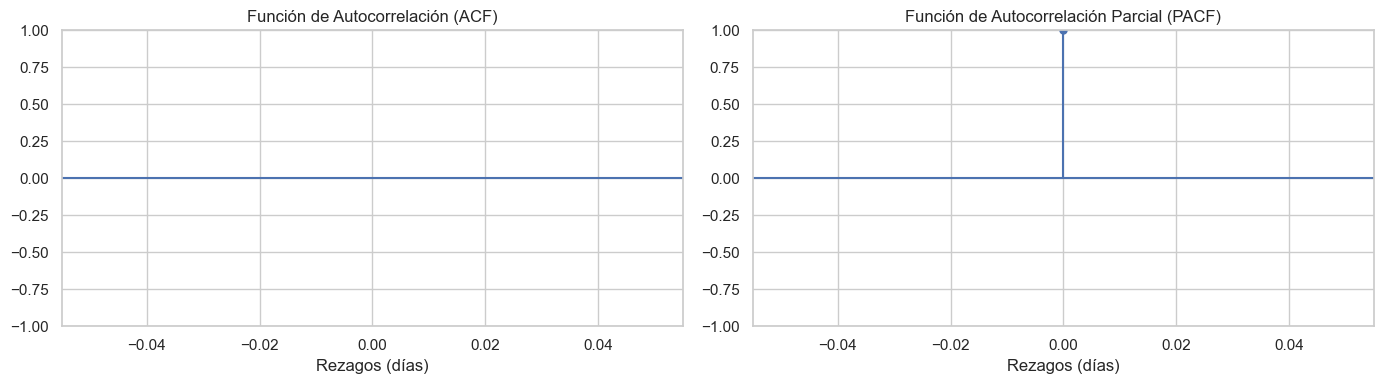

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Serie diaria agregada
serie_diaria = df.groupby("fecha", as_index=False)["ventas_diarias"].sum().set_index("fecha")
serie_diaria = serie_diaria.asfreq("D")

# Gráficos ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(serie_diaria["ventas_diarias"], ax=axes[0], lags=60, alpha=0.05)
axes[0].set_title("Función de Autocorrelación (ACF)")
axes[0].set_xlabel("Rezagos (días)")

plot_pacf(serie_diaria["ventas_diarias"], ax=axes[1], lags=60, alpha=0.05, method="ywm")
axes[1].set_title("Función de Autocorrelación Parcial (PACF)")
axes[1].set_xlabel("Rezagos (días)")

plt.tight_layout()
plt.show()


### **Preguntas clave para la Sección 7**

- ¿Existen outliers extremos no asociados a eventos reales?

- ¿Qué método se usa para su detección (IQR, z-score, visualización)?

- ¿Se deben conservar o corregir los valores detectados?

## **7. Detección de anomalías y valores atípicos**

Antes de aplicar un modelo de pronóstico, es importante identificar posibles valores atípicos o anomalías que puedan afectar la estabilidad de la serie temporal.

### **7.1 Concepto de valor atípico**
Un valor atípico es una observación que se aleja considerablemente del resto de los datos.  
En el contexto de ventas, los outliers suelen deberse a:
- Picos de demanda en eventos específicos (Black Friday, Cyber Monday, Navidad).  
- Errores de registro o cargas anómalas.  
- Cambios estructurales o promociones extraordinarias.




In [29]:
fig = px.box(
    df,
    y="ventas_diarias",
    title="Distribución de ventas diarias y detección visual de valores atípicos",
    labels={"ventas_diarias": "Ventas diarias (USD)"},
)
fig.update_traces(boxpoints="suspectedoutliers", marker=dict(color="red"))
fig.show()

### **7.2 Método de detección**
Se utilizarán dos enfoques complementarios:
1. **Visualización mediante boxplot** para detectar valores fuera del rango intercuartílico (IQR).  
2. **Marcado directo de outliers** en la serie temporal, destacando días con ventas anormalmente altas o bajas.

In [30]:
# Cálculo del rango intercuartílico (IQR)
q1 = df["ventas_diarias"].quantile(0.25)
q3 = df["ventas_diarias"].quantile(0.75)
iqr = q3 - q1

# Límites inferior y superior
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtrar los valores atípicos
outliers = df[(df["ventas_diarias"] < limite_inferior) | (df["ventas_diarias"] > limite_superior)]

print(f"Total de valores atípicos detectados: {len(outliers)}")
display(outliers[["fecha", "ventas_diarias", "categoria", "canal_venta", "tipo_promocion"]].head())


Total de valores atípicos detectados: 968


,fecha,ventas_diarias,categoria,canal_venta,tipo_promocion
8,2022-11-06,976.29,Electrónica,Tienda,Sin promo
15,2022-11-13,"3,656.66",Electrónica,Online,Sin promo
20,2022-11-28,"1,676.06",Tecnología,Online,Sin promo
27,2024-11-13,"1,948.60",Electrónica,Tienda,Sin promo
28,2024-11-22,"1,146.16",Electrónica,Tienda,Sin promo


In [31]:
# Agregar etiqueta de outlier a la serie
serie_diaria = df.groupby("fecha", as_index=False)["ventas_diarias"].sum()
serie_diaria["es_outlier"] = np.where(
    (serie_diaria["ventas_diarias"] < limite_inferior) | (serie_diaria["ventas_diarias"] > limite_superior),
    "Outlier",
    "Normal"
)

# Gráfico de la serie con outliers destacados
fig = px.scatter(
    serie_diaria,
    x="fecha",
    y="ventas_diarias",
    color="es_outlier",
    title="Ventas diarias con detección de valores atípicos (IQR)",
    labels={"fecha": "Fecha", "ventas_diarias": "Ventas diarias (USD)"},
)
fig.update_traces(marker=dict(size=5))
fig.show()


# **Conclusión Final del EDA**

El análisis exploratorio permitió identificar un comportamiento de ventas estable durante la mayor parte del año, con aumentos moderados hacia mitad de año y picos muy marcados en los meses de noviembre y diciembre. Estos incrementos corresponden claramente a eventos promocionales intensivos, como Black November, Black Friday y compras navideñas.

La descomposición de la serie temporal mostró una **tendencia suavemente creciente**, lo que indica un crecimiento orgánico en ventas a lo largo del tiempo. El componente estacional reflejó patrones repetitivos cada año, especialmente durante los meses promocionales, mientras que el residuo permaneció sin señales fuertes de comportamiento irregular.

El análisis por categoría y canal reveló que aunque existen diferencias entre segmentos, estas no son extremas: las ventas promedio son similares entre categorías y el comportamiento de Online y Tienda sigue patrones parecidos, aunque Online tiende a aumentar su participación en picos de demanda.  

La estacionalidad semanal también fue evidente: los días viernes, sábado y domingo concentran mayores ventas, mientras que entre semana la variación es mínima. Esto sugiere una estructura semanal estable que puede aprovecharse para el modelado.

En conjunto, el dataset queda bien estructurado, sin huecos y con patrones claros de tendencia y estacionalidad, proporcionando una base sólida para avanzar a la fase de modelado de forecasting.


# **Qué seguiría después del EDA**

- Construcción del dataset de modelado con variables lag, rolling y codificación temporal.
- Selección de modelos de forecasting (SARIMA, Prophet, XGBoost, LSTM).
- División temporal del conjunto de entrenamiento y prueba.
- Validación cruzada para series temporales (TimeSeriesSplit).
- Ajuste de hiperparámetros y evaluación con métricas (RMSE, MAE, MAPE).
- Comparación de modelos y selección final.
- Generación del forecast para el horizonte definido.
- Implementación de un pipeline automatizado de actualización y monitoreo.
